## Loading Data

In [1]:
# Loading Data and Libraries
# Loading Data Processing Packages
import numpy as np # linear algebra
import pandas as pd # data frame manipulation
from numpy import nan
from numpy import percentile
from numpy import isnan
from pandas import read_csv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MultiLabelBinarizer
import random
from scipy.stats import chi2_contingency

# importing dython for visualization of categorical data
!pip install dython
from dython import nominal
from dython.nominal import associations

# Loading Data Visualization Libraries
!pip install chart_studio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
!pip install dexplot


! pip install statsmodels
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm


     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 174kB 5.1MB/s 


In [2]:
patients = pd.read_csv("/content/demographic_data_codeathon_2021.csv") #loading data
display(patients)

,Patient Name,Race,Gender,Age,Glaucoma
0,Abudu91553621,Black,Female,47,Yes
1,Afinowicz73320600,White,Male,81,Yes
2,Aguilera71612740,Hispanic,Female,66,Yes
3,Alavi72502122,East Indian,Female,71,Yes
4,Alban7034,White,Female,85,Yes
...,...,...,...,...,...
72,Baker73079381,Black,Male,37,No
73,Baldwin71959320,Black,Female,70,No
74,Baldwin91863764,White,Male,69,No
75,Ballard70350612,White,Female,84,No


## Categorical Correlation

For initial visualization with categorical data, we will create a correlation heatmap using the associations function in the dython library.


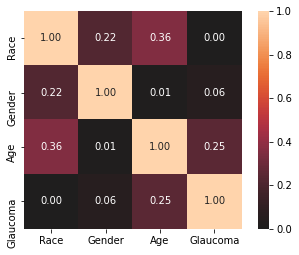

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fdd78433910>,
 'corr':               Race    Gender       Age  Glaucoma
 Race      1.000000  0.221473  0.356530  0.000000
 Gender    0.221473  1.000000  0.009238  0.060633
 Age       0.356530  0.009238  1.000000  0.246720
 Glaucoma  0.000000  0.060633  0.246720  1.000000}

In [3]:
heatmap = pd.DataFrame(patients)
# Remove name column as it is independent from glaucoma status and will not be useful for the heatmap.
heatmap = heatmap.drop(['Patient Name'], axis = 1)
nominal.associations(heatmap, nominal_columns=['Race','Gender', 'Glaucoma'])

## Exploratory Data Analysis


### Initial Analysis
First, let us obtain patient counts for glaucoma/normal, by race, gender, and age.

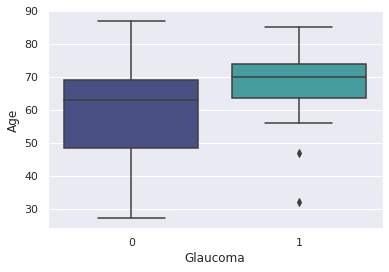

In [27]:
sns.boxplot(x='Glaucoma', y='Age', data=patients, palette="mako");

In [5]:
ge = patients.loc[(patients['Glaucoma'] == "Yes")]
he = patients.loc[(patients['Glaucoma'] == "No")]
quartiles = percentile(ge['Age'], [25, 50, 75])
five_num_summary = pd.DataFrame(columns=['Glaucoma', 'Minimum Age', 'Q1', 'Median', 'Q3', 'Maximum Age'])
ge = {'Glaucoma': "Yes", 'Minimum Age': ge['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': ge['Age'].max()}
five_num_summary = five_num_summary.append(ge, ignore_index=True)
quartiles = percentile(he['Age'], [25, 50, 75])
he = {'Glaucoma': "No", 'Minimum Age': he['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': he['Age'].max()}
five_num_summary = five_num_summary.append(he, ignore_index=True)
display(five_num_summary)

,Glaucoma,Minimum Age,Q1,Median,Q3,Maximum Age
0,Yes,32,63.5,70.0,74.0,85
1,No,27,48.5,63.0,69.0,87


Appears that the average age of those diagnosed with glaucoma is higher than those with normal OCTA scans.

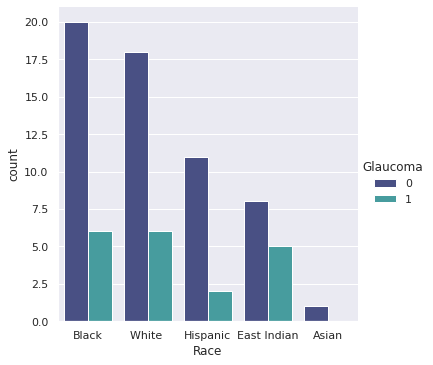

In [28]:
sns.catplot(x="Race", data=patients, hue = "Glaucoma", kind = "count", palette="mako")

Arranged in descending order of counts.

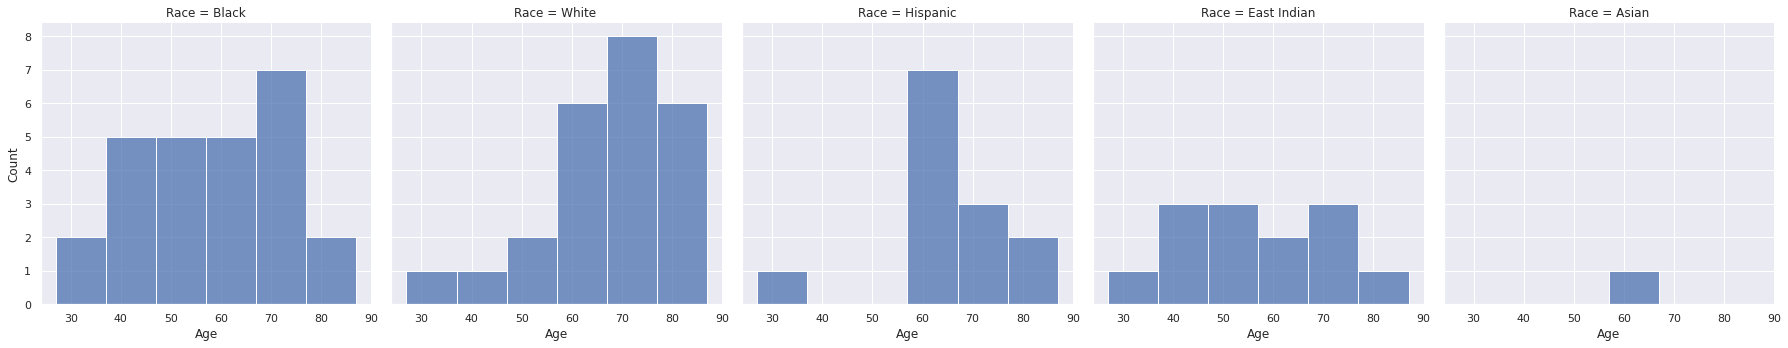

In [30]:
sns.set_theme(color_codes=True)
sns.displot(patients, x='Age', col = 'Race', binwidth = 10, palette = "mako") 

In [8]:
# calculate a 5-number summary 
# Only Looking at Black, White, Hispanic patients
black = patients.loc[(patients['Race'] == "Black")]
white = patients.loc[(patients['Race'] == "White ")]
hispanic = patients.loc[(patients['Race'] == "Hispanic")]
eastindian = patients.loc[(patients['Race'] == "East Indian")]
quartiles = percentile(black['Age'], [25, 50, 75])
five_num_summary = pd.DataFrame(columns=['Race', 'Minimum Age', 'Q1', 'Median', 'Q3', 'Maximum Age'])
black = {'Race': "Black", 'Minimum Age': black['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': black['Age'].max()}
five_num_summary = five_num_summary.append(black, ignore_index=True)
quartiles = percentile(hispanic['Age'], [25, 50, 75])
hispanic = {'Race': "Hispanic", 'Minimum Age': hispanic['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': hispanic['Age'].max()}
five_num_summary = five_num_summary.append(hispanic, ignore_index=True)
quartiles = percentile(eastindian['Age'], [25, 50, 75])
eastindian = {'Race': "East Indian", 'Minimum Age': eastindian['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': eastindian['Age'].max()}
five_num_summary= five_num_summary.append(eastindian, ignore_index=True)

quartiles = percentile(white['Age'], [25, 50, 75])
white = {'Race': "White", 'Minimum Age': white['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': white['Age'].max()}
five_num_summary = five_num_summary.append(white, ignore_index=True)

display(five_num_summary)

,Race,Minimum Age,Q1,Median,Q3,Maximum Age
0,Black,33,46.25,59.0,68.75,80
1,Hispanic,30,63.00,66.0,68.00,78
2,East Indian,27,46.00,56.0,71.00,82
3,White,32,62.75,69.0,76.50,87


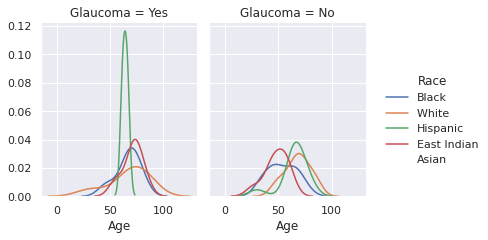

In [9]:
g = sns.FacetGrid(patients, col='Glaucoma', hue='Race', margin_titles=True, height=3.5, aspect=.8)
g.map(sns.distplot,'Age', hist = False, kde_kws=dict(alpha=0.6), bins = 8)
g.add_legend()  


In [10]:
patientsclean = patients
patientsclean['Race'].replace('Black', 0,inplace=True)
patientsclean['Race'].replace('Hispanic', 1,inplace=True)
patientsclean['Race'].replace('East Indian', 2,inplace=True)
patientsclean['Race'].replace('Asian', 3,inplace=True)
patientsclean['Race'].replace('White ', 4,inplace=True)


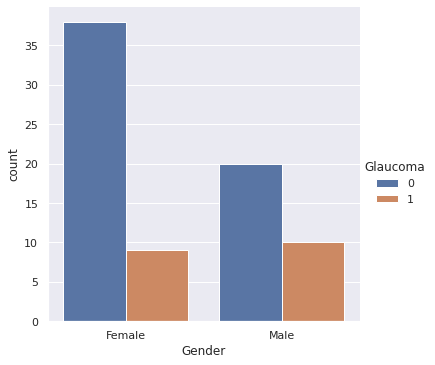

In [26]:
sns.catplot(x="Gender", data=patients, hue = "Glaucoma", kind = "count", palette = )

Clearly, far more female patients overall. Might have to augment male data in dataset by flipping, zooming on images as discussed.


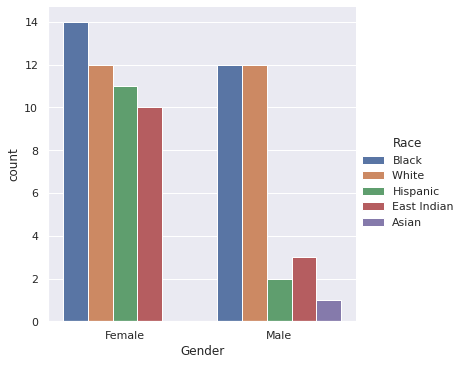

In [12]:
patients = pd.read_csv("/content/demographic_data_codeathon_2021.csv") #loading data
sns.catplot(x="Gender", data=patients, hue = "Race", kind = "count")

In [13]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum() 
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
patientsclean['Gender'].replace('Female', 0,inplace=True)
patientsclean['Gender'].replace('Male', 1,inplace=True)
confusion_matrix = pd.crosstab(patientsclean['Gender'], patients['Race']) 
cramers_corrected_stat(confusion_matrix) 

0.22147318753080167

With Cramer's V, seems to have a significant association between Gender and Race.

In [14]:
patientsclean['Glaucoma'].replace('No', 0,inplace=True)
patientsclean['Glaucoma'].replace('Yes', 1,inplace=True)
confusion_matrix = pd.crosstab(patientsclean['Gender'], patientsclean['Glaucoma']) 
cramers_corrected_stat(confusion_matrix) 

0.06063305608340936

Not a strong association with gender and glaucoma with nominal association computation.

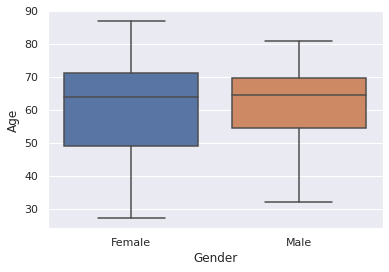

In [15]:
sns.boxplot(x='Gender', y='Age', data=patients);

In [16]:
f = patients.loc[(patients['Gender'] == "Female")]
m = patients.loc[(patients['Gender'] == "Male")]
quartiles = percentile(f['Age'], [25, 50, 75])
five_num_summary = pd.DataFrame(columns=['Gender', 'Minimum Age', 'Q1', 'Median', 'Q3', 'Maximum Age'])
f = {'Gender': "Female", 'Minimum Age': f['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': f['Age'].max()}
five_num_summary = five_num_summary.append(f, ignore_index=True)
quartiles = percentile(m['Age'], [25, 50, 75])
m = {'Gender': "Male", 'Minimum Age': m['Age'].min(), 'Q1': quartiles[0], 'Median': quartiles[1], 'Q3':quartiles[2],'Maximum Age': m['Age'].max()}
five_num_summary = five_num_summary.append(m, ignore_index=True)
display(five_num_summary)

,Gender,Minimum Age,Q1,Median,Q3,Maximum Age
0,Female,27,49.0,64.0,71.00,87
1,Male,32,54.5,64.5,69.75,81


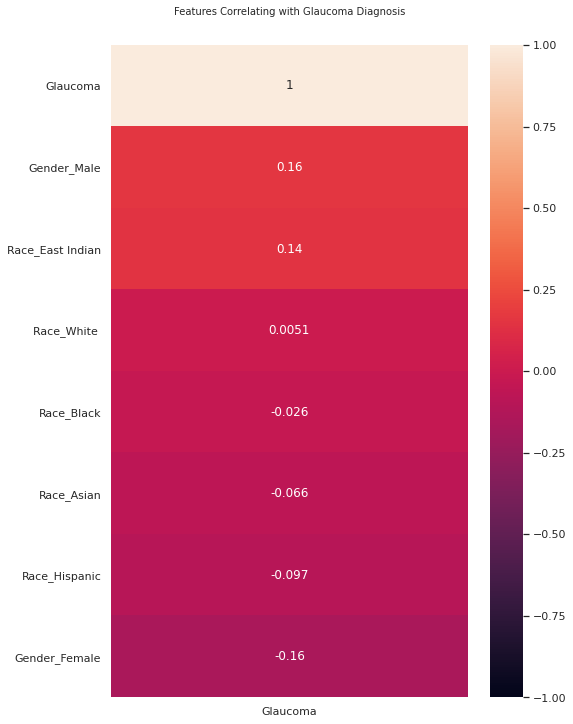

In [17]:
patientsclean = patients
patientsclean = pd.concat([patientsclean,pd.get_dummies(patientsclean['Race'], prefix='Race')],axis=1)
patientsclean = pd.concat([patientsclean,pd.get_dummies(patientsclean['Gender'], prefix='Gender')],axis=1)
patientsclean['Glaucoma'].replace('No', 0,inplace=True)
patientsclean['Glaucoma'].replace('Yes', 1,inplace=True)
del patientsclean['Race']
del patientsclean['Age']
del patientsclean['Gender']

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(patientsclean.corr()[['Glaucoma']].sort_values(by='Glaucoma', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Glaucoma Diagnosis', fontdict={'fontsize':10}, pad=30);


These features will most likely result in overfitting, decided against logistic regression.

In [18]:
patientsclean = patients
patientsclean['Glaucoma'].replace('No', 0,inplace=True)
patientsclean['Glaucoma'].replace('Yes', 1,inplace=True)

stats.pointbiserialr(patientsclean['Age'], patientsclean['Glaucoma']) # Continuous and binary

PointbiserialrResult(correlation=0.24671995412899853, pvalue=0.030532990290303718)

In [19]:
patients['Gender'].replace('Female', 0,inplace=True)
patients['Gender'].replace('Male', 1,inplace=True)
patients['Glaucoma'].replace('No', 0,inplace=True)
patients['Glaucoma'].replace('Yes', 1,inplace=True)

stats.pointbiserialr(patients['Age'], patients['Gender']) # Continuous and binary

PointbiserialrResult(correlation=0.009237811404323972, pvalue=0.9364462120348986)

Looks like there isn't a strong point biserial correlation coefficient between age and glaucoma status, but there is one between age and gender.

What if we considered age groups instead?


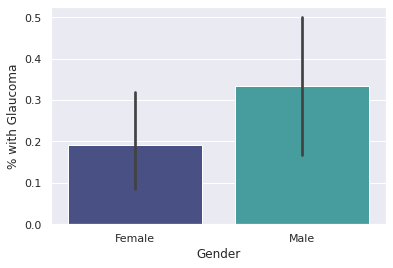

In [29]:
patients['Age Groups'] = pd.cut(patients['Age'], range(20, 91, 10), right=True, labels=['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
ax = sns.barplot(x="Gender", y="Glaucoma", data=patients, palette="mako")
ax.set(xlabel='Gender', ylabel= '% with Glaucoma')
plt.show()

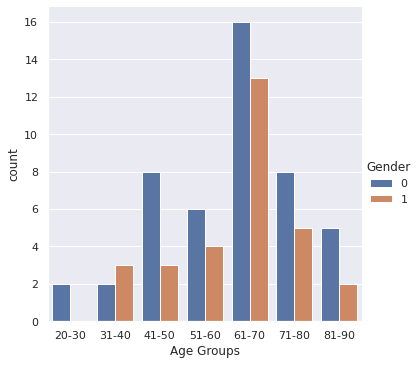

In [21]:
sns.catplot(x="Age Groups", data=patients, hue = "Gender", kind = "count")

In [22]:
patients['Age Groups'].replace('20-30', 0,inplace=True)
patients['Age Groups'].replace('31-40', 1,inplace=True)
patients['Age Groups'].replace('41-50', 2,inplace=True)
patients['Age Groups'].replace('51-60', 3,inplace=True)
patients['Age Groups'].replace('61-70', 4,inplace=True)
patients['Age Groups'].replace('71-80', 5,inplace=True)
patients['Age Groups'].replace('81-90', 6,inplace=True)
confusion_matrix = pd.crosstab(patients['Age Groups'], patients['Glaucoma']) 
cramers_corrected_stat(confusion_matrix) 

0.1498941159055593

In [23]:
patients['Gender'].replace(0, 'Female',inplace=True)
patients['Gender'].replace(1,'Male',inplace=True)
confusion_matrix = pd.crosstab(patients['Age Groups'], patients['Gender']) 
cramers_corrected_stat(confusion_matrix) 

0.0

Looks like there is a fairly weak association between age groups and glaucoma diagnosis. Also, there appears to be no Cramer's V association between Age group and gender.

## Key Takeaways
* Developed script to provide 5 number summaries and EDA.
* Found that the model using the demographic data alone could result in overfitting/not representative of what is currently known - might be worth augmenting the dataset to account for the skewed distribution.
* Considering findings using age groups might be worth considering feature engineering (specifically feature binning of age?).


## anova Test
In ANOVA, the dependent variable must be a continuous (interval or ratio) level of measurement. The independent variables in ANOVA must be categorical (nominal or ordinal) variables. Like the t-test, ANOVA is also a parametric test and has some assumptions. ANOVA assumes that the data is normally distributed.
(Not useful)

In [24]:
anova = ols('Glaucoma ~ Race + Gender + Age', data=patients).fit() #Glaucoma as dependent
print(sm.stats.anova_lm(anova))


            df     sum_sq   mean_sq         F    PR(>F)
Race       4.0   0.427073  0.106768  0.611633  0.655634
Gender     1.0   0.465852  0.465852  2.668683  0.106831
Age        1.0   1.199392  1.199392  6.870849  0.010739
Residual  70.0  12.219371  0.174562       NaN       NaN
